In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt

%matplotlib inline


Matplotlib is building the font cache; this may take a moment.


In [2]:
from typing import List, Tuple, Optional

class RiskSetMatcher:
    """
    A class to perform Risk Set Matching for observational studies.
    """

    def __init__(self, 
                 time_column: str = 'time',
                 treatment_column: str = 'treatment',
                 patient_id_column: str = 'patient_id',
                 covariate_columns: Optional[List[str]] = None):
        """
        Initialize the RiskSetMatcher.
        """
        self.time_column = time_column
        self.treatment_column = treatment_column
        self.patient_id_column = patient_id_column
        self.covariate_columns = covariate_columns
        self.scaler = StandardScaler()
        self.cov_inv = None

    def fit(self, data: pd.DataFrame) -> None:
        """
        Fit the matcher to the data by computing the covariance matrix and scaling parameters.
        """
        if self.covariate_columns is None:
            # Automatically detect numeric columns if not specified
            self.covariate_columns = data.select_dtypes(include=[np.number]).columns.tolist()
            self.covariate_columns = [col for col in self.covariate_columns 
                                      if col not in [self.time_column, self.treatment_column, self.patient_id_column]]
                
        # Standardize covariates
        self.scaler.fit(data[self.covariate_columns])

        # Calculate inverse covariance matrix for Mahalanobis distance
        scaled_data = self.scaler.transform(data[self.covariate_columns])
        cov_matrix = np.cov(scaled_data, rowvar=False)
        try:
            self.cov_inv = np.linalg.inv(cov_matrix)
        except np.linalg.LinAlgError:
            warnings.warn("Covariance matrix is singular. Using pseudoinverse instead.")
            self.cov_inv = np.linalg.pinv(cov_matrix)

    def _calculate_distances(self, treated_patient: pd.Series, potential_controls: pd.DataFrame) -> np.ndarray:
        """
        Calculate Mahalanobis distances between treated patient and potential controls.
        """
        # Convert treated_patient to DataFrame with correct feature names
        treated_covs = self.scaler.transform(
            treated_patient[self.covariate_columns].to_frame().T
        )

        control_covs = self.scaler.transform(
            potential_controls[self.covariate_columns]
        )

        diff = control_covs - treated_covs
        distances = np.sqrt(np.sum(diff.dot(self.cov_inv) * diff, axis=1))
        return distances

    def match(self, data: pd.DataFrame, caliper: Optional[float] = None) -> List[Tuple]:
        """
        Perform risk set matching on the data.
        """
        if self.cov_inv is None:
            self.fit(data)

        matched_pairs = []
        # Commented out used_controls to allow matching with replacement
        # used_controls = set()

        # Sort by time to ensure proper risk set construction
        data = data.sort_values(self.time_column)

        treated_patients = data[data[self.treatment_column] == 1]

        for _, treated in treated_patients.iterrows():
            # Find eligible controls (not yet treated)
            potential_controls = data[
                (data[self.treatment_column] == 0) &
                (data[self.time_column] <= treated[self.time_column])
                # & (~data[self.patient_id_column].isin(used_controls))  # Allow controls to be reused
            ]

            if len(potential_controls) == 0:
                warnings.warn(f"No eligible controls found for treated patient {treated[self.patient_id_column]}")
                continue

            # Calculate distances
            distances = self._calculate_distances(treated, potential_controls)

            # Apply caliper if specified
            if caliper is not None:
                valid_matches = distances <= caliper
                if not any(valid_matches):
                    warnings.warn(f"No controls within caliper for treated patient {treated[self.patient_id_column]}")
                    continue
                potential_controls = potential_controls.iloc[valid_matches]
                distances = distances[valid_matches]

            # Find best match
            best_match_idx = np.argmin(distances)
            matched_control = potential_controls.iloc[best_match_idx]

            matched_pairs.append((
                treated[self.patient_id_column],
                matched_control[self.patient_id_column],
                distances[best_match_idx]
            ))

            # Allowing controls to be matched multiple times
            # used_controls.add(matched_control[self.patient_id_column])

        return matched_pairs

    def assess_balance(self, data: pd.DataFrame, matched_pairs: List[Tuple]) -> pd.DataFrame:
        """
        Assess covariate balance between matched treated and control groups.
        """
        treated_ids = [pair[0] for pair in matched_pairs]
        control_ids = [pair[1] for pair in matched_pairs]

        treated_data = data[data[self.patient_id_column].isin(treated_ids)]
        control_data = data[data[self.patient_id_column].isin(control_ids)]

        balance_stats = []

        for col in self.covariate_columns:
            treated_mean = treated_data[col].mean()
            treated_std = treated_data[col].std()
            control_mean = control_data[col].mean()
            control_std = control_data[col].std()

            # Compute standardized mean difference
            pooled_std = np.sqrt((treated_std ** 2 + control_std ** 2) / 2)
            std_diff = (treated_mean - control_mean) / pooled_std

            balance_stats.append({
                'covariate': col,
                'treated_mean': treated_mean,
                'control_mean': control_mean,
                'std_diff': std_diff,
                'treated_std': treated_std,
                'control_std': control_std
            })

        return pd.DataFrame(balance_stats)


In [3]:
# Create sample data
np.random.seed(42)
n_patients = 1000

data = pd.DataFrame({
    'patient_id': range(n_patients),
    'time': np.random.uniform(0, 100, n_patients),
    'treatment': np.random.binomial(1, 0.3, n_patients),
    'age': np.random.normal(65, 10, n_patients),
    'blood_pressure': np.random.normal(120, 15, n_patients),
    'glucose': np.random.normal(100, 20, n_patients)
})


In [4]:
# Initialize and run the matcher
matcher = RiskSetMatcher(
    covariate_columns=['age', 'blood_pressure', 'glucose']
)

# Increased caliper value to 5.0
matched_pairs = matcher.match(data, caliper=5.0)

print(f"Number of matched pairs: {len(matched_pairs)}")


Number of matched pairs: 307


In [5]:
# Function to compute balance statistics
def compute_balance(data, treated_ids, control_ids, covariate_columns):
    treated_data = data[data['patient_id'].isin(treated_ids)]
    control_data = data[data['patient_id'].isin(control_ids)]

    balance_stats = []

    for col in covariate_columns:
        treated_mean = treated_data[col].mean()
        treated_std = treated_data[col].std()
        control_mean = control_data[col].mean()
        control_std = control_data[col].std()

        # Compute standardized mean difference
        pooled_std = np.sqrt((treated_std ** 2 + control_std ** 2) / 2)
        std_diff = (treated_mean - control_mean) / pooled_std

        balance_stats.append({
            'covariate': col,
            'treated_mean': treated_mean,
            'control_mean': control_mean,
            'std_diff': std_diff,
            'treated_std': treated_std,
            'control_std': control_std
        })

    return pd.DataFrame(balance_stats)

# Balance before matching
treated_ids_before = data[data['treatment'] == 1]['patient_id']
control_ids_before = data[data['treatment'] == 0]['patient_id']

balance_stats_before = compute_balance(data, treated_ids_before, control_ids_before, ['age', 'blood_pressure', 'glucose'])
balance_stats_before['matched'] = 'Before Matching'

# Balance after matching
treated_ids_after = [pair[0] for pair in matched_pairs]
control_ids_after = [pair[1] for pair in matched_pairs]

balance_stats_after = compute_balance(data, treated_ids_after, control_ids_after, ['age', 'blood_pressure', 'glucose'])
balance_stats_after['matched'] = 'After Matching'

# Combine for plotting
balance_stats_combined = pd.concat([balance_stats_before, balance_stats_after]).reset_index(drop=True)
balance_stats_combined


,covariate,treated_mean,control_mean,std_diff,treated_std,control_std,matched
0,age,65.079164,65.151479,-0.007457,9.462791,9.926040,Before Matching
1,blood_pressure,120.766609,119.711436,0.068792,15.315258,15.361931,Before Matching
2,glucose,99.715693,98.488972,0.062188,19.552822,19.897648,Before Matching
3,age,65.079164,65.078780,0.000040,9.462791,9.542434,After Matching
4,blood_pressure,120.766609,120.626633,0.009239,15.315258,14.983818,After Matching
5,glucose,99.715693,98.467392,0.064964,19.552822,18.871509,After Matching


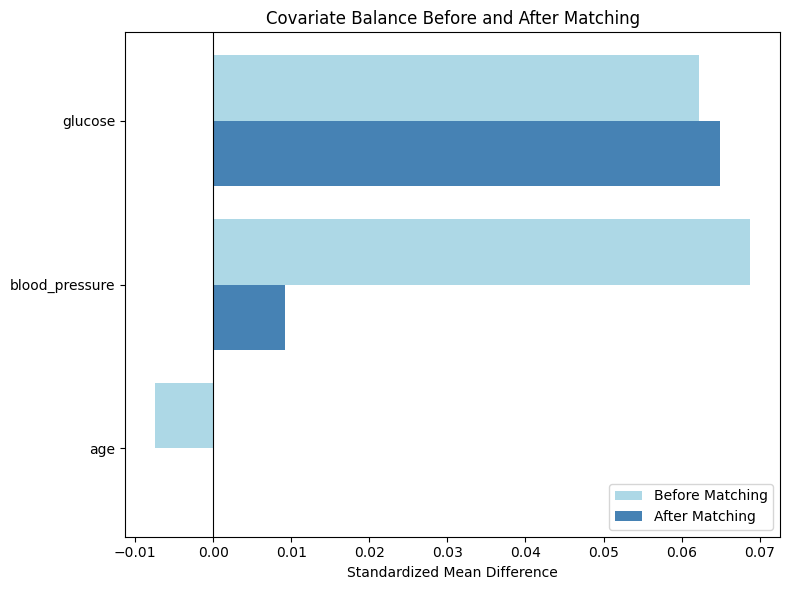

In [6]:
# Pivot the DataFrame for plotting
balance_pivot = balance_stats_combined.pivot(index='covariate', columns='matched', values='std_diff')

# Plot standardized mean differences
fig, ax = plt.subplots(figsize=(8, 6))

covariates = balance_pivot.index
before_smd = balance_pivot['Before Matching'].values
after_smd = balance_pivot['After Matching'].values

# Position of the bars on the y-axis
y_pos = np.arange(len(covariates))

# Plotting standardized mean differences before matching
ax.barh(y_pos + 0.2, before_smd, height=0.4, color='lightblue', label='Before Matching')

# Plotting standardized mean differences after matching
ax.barh(y_pos - 0.2, after_smd, height=0.4, color='steelblue', label='After Matching')

ax.set_yticks(y_pos)
ax.set_yticklabels(covariates)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Standardized Mean Difference')
ax.set_title('Covariate Balance Before and After Matching')
ax.legend()
plt.tight_layout()
plt.show()


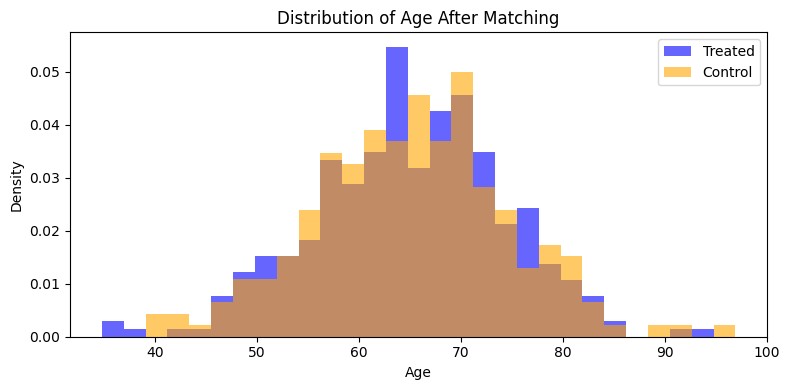

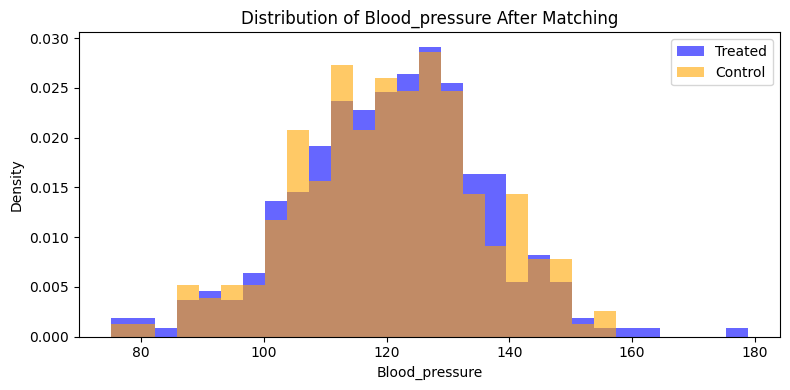

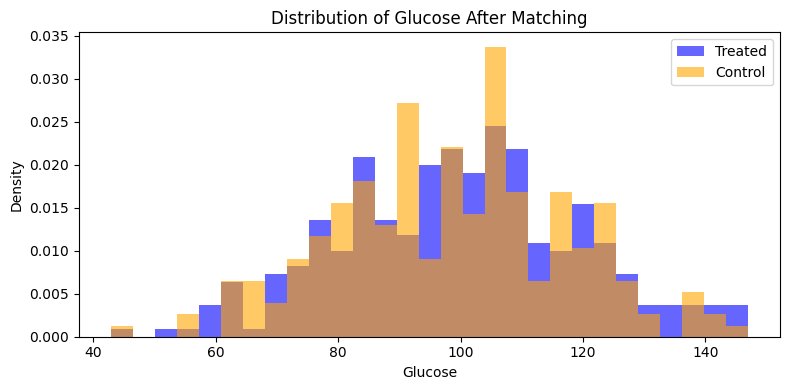

In [7]:
# Create dataframes for plotting distributions
matched_treated = data[data['patient_id'].isin(treated_ids_after)].copy()
matched_control = data[data['patient_id'].isin(control_ids_after)].copy()

for col in ['age', 'blood_pressure', 'glucose']:
    plt.figure(figsize=(8, 4))
    bins = np.linspace(
        min(matched_treated[col].min(), matched_control[col].min()),
        max(matched_treated[col].max(), matched_control[col].max()),
        30
    )

    # Histogram for treated group
    plt.hist(
        matched_treated[col],
        bins=bins,
        alpha=0.6,
        label='Treated',
        density=True,
        color='blue'
    )

    # Histogram for control group
    plt.hist(
        matched_control[col],
        bins=bins,
        alpha=0.6,
        label='Control',
        density=True,
        color='orange'
    )

    plt.title(f'Distribution of {col.capitalize()} After Matching')
    plt.xlabel(col.capitalize())
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:
# Display first 5 matched pairs
print("Matched Pairs (first 5):")
for pair in matched_pairs[:5]:
    print(f"Treated ID: {int(pair[0])}, Control ID: {int(pair[1])}, Distance: {pair[2]:.3f}")


Matched Pairs (first 5):
Treated ID: 205, Control ID: 72, Distance: 1.478
Treated ID: 407, Control ID: 128, Distance: 2.214
Treated ID: 244, Control ID: 563, Distance: 0.421
Treated ID: 171, Control ID: 128, Distance: 1.065
Treated ID: 874, Control ID: 312, Distance: 1.063
